In [1]:
import os
import numpy as np
import efficientnet.tfkeras
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Model, model_from_json
from tensorflow.keras import optimizers

os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [2]:
path_model = "/media/tohn/HDD/Model_unlearn/Models_USAI/ML-unlearn/R2/unfreezeB4-B7/models/modelEffNetB5_ML-unlearn_unfreezeB4-B7-R2.h5"
model = load_model(path_model)
height = width = model.input_shape[1]
input_shape = (height, width, 3)
print(input_shape)
print("*"*125)
model.summary()

(456, 456, 3)
*****************************************************************************************************************************
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
new_input (InputLayer)       [(None, 456, 456, 3)]     0         
_________________________________________________________________
efficientnet-b5 (Functional) (None, None, None, 2048)  28513520  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
prediction_layer (Dense)     (None, 15)                30735     
Total params: 28,544,255
Trainable params: 26,859,743
Non-trainable params: 1,684,512
_________________________________

In [3]:
# validation
import pandas as pd
base_dir = '/media/tohn/SSD/Images/Image1'
dataframe = pd.read_csv( '/media/tohn/HDD/VISION_dataset/Valdf_fold3_v2.csv')#แก้
validation_dir = os.path.join(base_dir, 'test')

#Train
train_df = pd.read_csv( '/media/tohn/HDD/VISION_dataset/Traindf_fold4_8_v2.csv')#แก้
base_dir = '/media/tohn/SSD/Images/Image1'
os.chdir(base_dir)
train_dir = os.path.join(base_dir, 'train')

In [4]:
import pandas as pd
df0 = pd.read_csv('/media/tohn/HDD/VISION_dataset/Testdf_fold1_2_v1.csv')
print(df0 .shape)
dataframe = df0[(df0['Path Crop']!='None' )&(df0['Path Crop']!='Nan')]
print(dataframe.shape)
# print('Normal: ',dataframe[dataframe['Class']=='Normal'].shape)
# print('Abnormal: ',dataframe[dataframe['Class']=='Abnormal'].shape)
dataframe.head(5)

(1312, 27)
(1312, 27)


,Unnamed: 0,Case,Abs Position,Sub Position,Class,Path Full,Path Crop,Views,fold,15AB,...,Rwidth,Rheight,Sub_class_New,tag_AjNit,tag_AjWan,Test150,Spilt,Sub_Position_New,filename,Sub_Position_Label
0,111,40,P1,P1,Abnormal,/media/tohn/HDD/VISION_dataset/USAI/ABnormal01...,/media/tohn/HDD/VISION_dataset/USAI/ABnormal01...,FP-A,2,MildFattyLiver,...,0.513514,0.346614,AB01,NaN,NaN,False,Test,P1,AB01 P1 C040.JPG,P1
1,112,40,P2,P2,Abnormal,/media/tohn/HDD/VISION_dataset/USAI/ABnormal01...,/media/tohn/HDD/VISION_dataset/USAI/ABnormal01...,FP-A,2,MildFattyLiver,...,0.560377,0.428287,AB01,NaN,NaN,False,Test,P2,AB01 P2 C040.JPG,P2
2,113,40,P4,P41,Abnormal,/media/tohn/HDD/VISION_dataset/USAI/ABnormal01...,/media/tohn/HDD/VISION_dataset/USAI/ABnormal01...,FP-B,2,MildFattyLiver,...,0.667984,0.711155,AB01,NaN,NaN,False,Test,P4,AB01 P4-1 C040.JPG,P4
3,114,40,P5,P51,Abnormal,/media/tohn/HDD/VISION_dataset/USAI/ABnormal01...,/media/tohn/HDD/VISION_dataset/USAI/ABnormal01...,FP-C,2,MildFattyLiver,...,0.690385,0.653386,AB01,NaN,NaN,False,Test,P6,AB01 P5-1 C040.JPG,P6
4,115,40,P3,P31,Abnormal,/media/tohn/HDD/VISION_dataset/USAI/ABnormal01...,/media/tohn/HDD/VISION_dataset/USAI/ABnormal01...,FP-B,2,MildFattyLiver,...,0.672515,0.625498,AB01,NaN,NaN,False,Test,P3,AB01 P3-1 C040.JPG,P3


In [5]:
len(set(dataframe['Sub_class_New']))

15

In [6]:
batch_size = 16

from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=30,
      width_shift_range=0.2,
      height_shift_range=0.2,
      brightness_range=[0.5,1.5],
      shear_range=0.4,
      zoom_range=0.2,
      horizontal_flip=False,
      fill_mode='nearest')

train_generator = train_datagen.flow_from_dataframe(
        dataframe = dataframe,
        directory = train_dir,
        x_col = 'Path Crop',
        y_col = 'Sub_class_New',
        target_size = (height, width),
        batch_size=batch_size,
        color_mode= 'rgb',
        class_mode='categorical')

#label
labels = (train_generator.class_indices)
labels = dict((v,k.replace("C","")) for k,v in labels.items())
print(labels)

Found 1312 validated image filenames belonging to 15 classes.
{0: 'AB01', 1: 'AB02', 2: 'AB03', 3: 'AB04', 4: 'AB05', 5: 'AB06', 6: 'AB07', 7: 'AB081', 8: 'AB082', 9: 'AB083', 10: 'AB09', 11: 'AB10', 12: 'AB11', 13: 'AB12', 14: 'Normal'}


# Prediction

In [7]:
from tensorflow.keras.preprocessing import image
def predict_image(img_path):
    # Read the image and resize it
    img = image.load_img(img_path, target_size=(height, width))
    # Convert it to a Numpy array with target shape.
    x = image.img_to_array(img)
    # Reshape
    x = x.reshape((1,) + x.shape)
    x /= 255.
    result = model.predict([x])
    
    return result[0]

#Predict
pred_list = list()
prob_list = list()
img_path=dataframe['Path Crop'].tolist()
for i in range(0,len(img_path)):
    predict = predict_image(img_path[i])
    result = np.argmax(predict)
    pred_list.append(labels[result])
    prob_list.append(predict[result])
    print(i)

dataframe['category'] = pred_list
dataframe['Prob'] = prob_list

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

# Evaluation

In [8]:
data_train = dataframe
#เช็คคลาสใน Predicted
pred_class = set(data_train['category'])
print('Predicted : ',len(pred_class))
print(pred_class)
#เช็คคลาสใน Actual
classe = set(data_train['Sub_class_New'])
print('Actual : ',len(classe))
print(classe)

Predicted :  15
{'AB01', 'AB09', 'AB083', 'AB082', 'AB11', 'AB02', 'AB05', 'AB06', 'AB03', 'AB12', 'Normal', 'AB07', 'AB081', 'AB04', 'AB10'}
Actual :  15
{'AB06', 'AB01', 'AB09', 'AB082', 'AB083', 'AB02', 'AB05', 'AB11', 'AB03', 'AB12', 'Normal', 'AB07', 'AB081', 'AB04', 'AB10'}


In [9]:
import numpy as np
from sklearn.metrics import confusion_matrix
act = data_train['Sub_class_New'].array
pred = data_train['category'].array

cmat = confusion_matrix(act, pred)
print('classifier accuracy = {}%'.format((100.*np.trace(cmat))/(np.sum(cmat))))

#Marking the Confusion Matrix
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(act, pred))#performance

classifier accuracy = 89.2530487804878%
              precision    recall  f1-score   support

        AB01       0.81      0.68      0.74        74
        AB02       0.67      0.58      0.62        59
        AB03       0.55      0.63      0.59        19
        AB04       0.96      0.58      0.72        38
        AB05       0.88      0.79      0.84        29
        AB06       0.67      0.67      0.67        21
        AB07       0.85      0.52      0.65        21
       AB081       0.88      0.66      0.75        32
       AB082       0.94      0.57      0.71        28
       AB083       0.62      0.73      0.67        11
        AB09       0.96      0.88      0.92        26
        AB10       0.89      0.80      0.84        10
        AB11       0.96      0.93      0.94        55
        AB12       0.88      0.91      0.89        32
      Normal       0.92      0.99      0.96       857

    accuracy                           0.89      1312
   macro avg       0.83      0.73      0

Text(0.5, 21.5, 'Predicted label')

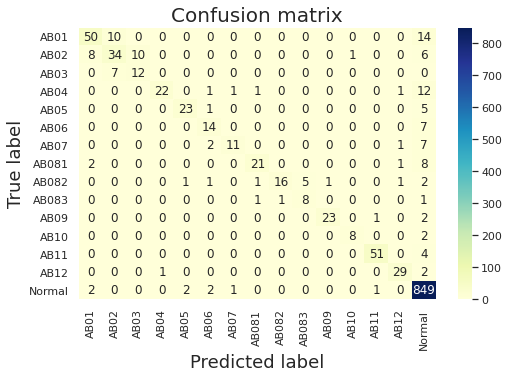

In [10]:
#create CF 
data = {'Actual': act,'Predicted' : pred,}
df = pd.DataFrame(data, columns=['Actual','Predicted'])
conf_mat = pd.crosstab(df['Actual'],df['Predicted'],rownames=['Actual'],colnames=['Predicted'])

#Confusion matrix
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
cm = confusion_matrix(act, pred)

#plot Confusion matrix
import seaborn as sns
sns.set()
fig, ax = plt.subplots(figsize=(8, 5))

ax = sns.heatmap(conf_mat, annot=True, fmt="d", cmap="YlGnBu") #Blues,Oranges,Reds
ax.set_title('Confusion matrix',fontsize=20)
ax.set_ylabel('True label',fontsize=18)
ax.set_xlabel('Predicted label',fontsize=18)

In [11]:
# act= p1['Sub_class_New'].map({'AB12':1, 'AB04':1, 'AB05':1, 'Normal':0, 'AB02':1, 'AB11':1, 'AB082':1, 'AB06':1,'AB07':1, 'AB081':1, 'AB09':1, 'AB03':1, 'AB10':1, 'AB01':1, 'AB083':1}).values
act= data_train['Sub_class_New'].map({'AB12':1, 'AB04':1, 'AB05':1, 'Normal':0, 'AB02':1, 'AB11':1, 'AB082':1, 'AB06':1,'AB07':1, 'AB081':1, 'AB09':1, 'AB03':1, 'AB10':1, 'AB01':1, 'AB083':1}).values
pred = data_train['category'].map({'AB12':1, 'AB04':1, 'AB05':1, 'Normal':0, 'AB02':1, 'AB11':1, 'AB082':1, 'AB06':1,'AB07':1, 'AB081':1, 'AB09':1, 'AB03':1, 'AB10':1, 'AB01':1, 'AB083':1}).values
cmat = confusion_matrix(act, pred)
print('classifier accuracy = {}%'.format((100.*np.trace(cmat))/(np.sum(cmat))))

#Marking the Confusion Matrix
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(act, pred))#performance

classifier accuracy = 93.90243902439025%
              precision    recall  f1-score   support

           0       0.92      0.99      0.96       857
           1       0.98      0.84      0.91       455

    accuracy                           0.94      1312
   macro avg       0.95      0.92      0.93      1312
weighted avg       0.94      0.94      0.94      1312



849 8 72 383


Text(48.5, 0.5, 'True label')

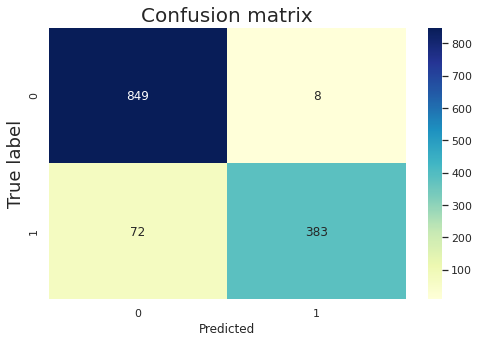

In [12]:
#create CF 
data = {'Actual': act,'Predicted' : pred,}
df = pd.DataFrame(data, columns=['Actual','Predicted'])
conf_mat = pd.crosstab(df['Actual'],df['Predicted'],rownames=['Actual'],colnames=['Predicted'])

#Confusion matrix
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
cm = confusion_matrix(act, pred)
TN, FP, FN, TP = confusion_matrix(act, pred).ravel()
print(TN, FP, FN, TP)
#plot Confusion matrix
import seaborn as sns
sns.set()
fig, ax = plt.subplots(figsize=(8, 5))

ax = sns.heatmap(conf_mat, annot=True, fmt="d", cmap="YlGnBu") #Blues,Oranges,Reds
ax.set_title('Confusion matrix',fontsize=20)
ax.set_ylabel('True label',fontsize=18)

In [13]:
Sub_class_New = list(set(dataframe['Sub_class_New']))

for i in range(len(Sub_class_New)):
    df = dataframe[dataframe['Sub_class_New'] == Sub_class_New[i]]
    
    act = df['Sub_class_New'].array
    pred = df['category'].array

    cmat = confusion_matrix(act, pred)
    print('######', Sub_class_New[i])
#     print(cmat)
#     print(classification_report(act, pred))
    
    print('classifier accuracy = {}% \n'.format((np.trace(cmat))/(np.sum(cmat))))

###### AB06
classifier accuracy = 0.6666666666666666% 

###### AB01
classifier accuracy = 0.6756756756756757% 

###### AB09
classifier accuracy = 0.8846153846153846% 

###### AB082
classifier accuracy = 0.5714285714285714% 

###### AB083
classifier accuracy = 0.7272727272727273% 

###### AB02
classifier accuracy = 0.576271186440678% 

###### AB05
classifier accuracy = 0.7931034482758621% 

###### AB11
classifier accuracy = 0.9272727272727272% 

###### AB03
classifier accuracy = 0.631578947368421% 

###### AB12
classifier accuracy = 0.90625% 

###### Normal
classifier accuracy = 0.9906651108518086% 

###### AB07
classifier accuracy = 0.5238095238095238% 

###### AB081
classifier accuracy = 0.65625% 

###### AB04
classifier accuracy = 0.5789473684210527% 

###### AB10
classifier accuracy = 0.8% 

